<a href="https://colab.research.google.com/github/YannSc/cleverhans/blob/master/AdversarialPatch_py3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adversarial Patch

Code from [Adversarial Patch (Tom B. Brown, Dandelion Mané, Aurko Roy, Martín Abadi, Justin Gilmer)](https://arxiv.org/abs/1712.09665)



![image](https://user-images.githubusercontent.com/306655/35713295-6f5f8e90-077b-11e8-9c78-ede4ed549bd1.png)



## Dependencies and Imports

In [43]:
# Install requirements
! pip install keras
! pip install git+https://github.com/nottombrown/imagenet_stubs --upgrade
! pip install tensorflow-gpu==1.15
  
# Create a directory to store our results
! mkdir /content/adversarial_patch

# Download a baseline true toaster image
! wget -O /content/adversarial_patch/toaster.png https://user-images.githubusercontent.com/306655/35698271-658aba28-0741-11e8-898b-5a3134634e9e.png

  Cloning https://github.com/nottombrown/imagenet_stubs to /tmp/pip-req-build-2_bb9lfp
  Running command git clone -q https://github.com/nottombrown/imagenet_stubs /tmp/pip-req-build-2_bb9lfp
  Created wheel for imagenet-stubs: filename=imagenet_stubs-0.0.7-cp36-none-any.whl size=794841 sha256=0d260ed93cf107e284cca0e869dbcd8190f7880acb4960193613f4b82b1bea22
  Stored in directory: /tmp/pip-ephem-wheel-cache-2f10v69b/wheels/ae/51/e7/c1cfa8692ea864410aa778b169fc7766af073ac52a1bc23301
Successfully built imagenet-stubs
  Found existing installation: imagenet-stubs 0.0.7
    Uninstalling imagenet-stubs-0.0.7:
      Successfully uninstalled imagenet-stubs-0.0.7


mkdir: cannot create directory ‘/content/adversarial_patch’: File exists
--2020-05-15 15:28:09--  https://user-images.githubusercontent.com/306655/35698271-658aba28-0741-11e8-898b-5a3134634e9e.png
Resolving user-images.githubusercontent.com (user-images.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to user-images.githubusercontent.com (user-images.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37989 (37K) [image/png]
Saving to: ‘/content/adversarial_patch/toaster.png’

/content/adversaria 100%[===================>]  37.10K  --.-KB/s    in 0.004s  

2020-05-15 15:28:09 (8.72 MB/s) - ‘/content/adversarial_patch/toaster.png’ saved [37989/37989]



In [0]:
import matplotlib.pyplot as plt
import pdb
import tensorflow as tf

import math
from matplotlib import pylab as P
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import defaultdict

import os
import os.path as osp
import numpy as np
import pickle
import io 
import PIL.Image
import scipy
import time
import glob
import random

import keras
from keras import applications
from keras import backend as K
from keras.preprocessing import image
import numpy as np

import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import label_to_name, name_to_label

## Hyperparameters

In [0]:
TARGET_LABEL = name_to_label('toaster') # Try "banana", "Pembroke, Pembroke Welsh corgi"
PATCH_SHAPE = (299, 299, 3)
BATCH_SIZE = 16

# Ensemble of models
NAME_TO_MODEL = {
    'xception': applications.xception.Xception,
    'vgg16': applications.vgg16.VGG16,
    'vgg19': applications.vgg19.VGG19,
    'resnet50': applications.resnet50.ResNet50,
    'inceptionv3': applications.inception_v3.InceptionV3,
}

# MODEL_NAMES = ['resnet50', 'xception', 'inceptionv3', 'vgg16', 'vgg19']
MODEL_NAMES = [ 'vgg16', 'vgg19']

# Data augmentation
# Empirically found that training with a very wide scale range works well
# as a default
SCALE_MIN = 0.3
SCALE_MAX = 1.5
ROTATE_MAX = np.pi/8 # 22.5 degrees in either direction

MAX_ROTATION = 22.5

# Local data dir to write files to
DATA_DIR = '/content/adversarial_patch'

## Image loading

Example true image:


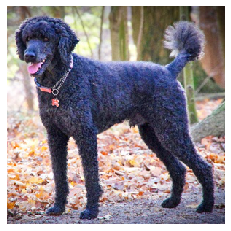

Example true image:


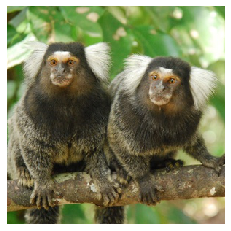

In [46]:
def _convert(im):
  return ((im + 1) * 127.5).astype(np.uint8)

def show(im):
  plt.axis('off')
  plt.imshow(_convert(im), interpolation="nearest")
  plt.show()
  
def load_image(image_path):
  im = PIL.Image.open(image_path)
  im = im.resize((299, 299), PIL.Image.ANTIALIAS)
  if image_path.endswith('.png'):
    ch = 4
  else:
    ch = 3
  im = np.array(im.getdata()).reshape(im.size[0], im.size[1], ch)[:,:,:3]
  return im / 127.5 - 1


class StubImageLoader():
  """An image loader that uses just a few ImageNet-like images. 
  In the actual paper, we used real ImageNet images, but we can't include them 
  here because of licensing issues.
  """
  def __init__(self):
    self.images = []
    self.toaster_image = None
   
    for image_path in imagenet_stubs.get_image_paths():
      im = load_image(image_path)

      if image_path.endswith('toaster.jpg'):
        self.toaster_image = im
      else:
        self.images.append(im)

  def get_images(self):
    return random.sample(self.images, BATCH_SIZE)

image_loader = StubImageLoader()

for example_image in image_loader.get_images()[:2]:
  print("Example true image:")
  show(example_image)
  

## Patch Transformations

Test image with random transform: 1


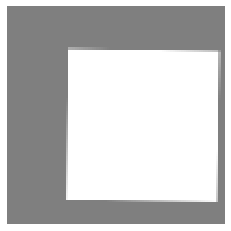

Test image with random transform: 2


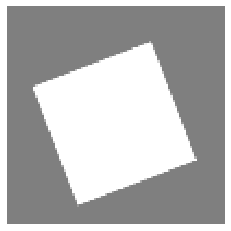

In [47]:
def _transform_vector(width, x_shift, y_shift, im_scale, rot_in_degrees):
  """
   If one row of transforms is [a0, a1, a2, b0, b1, b2, c0, c1], 
   then it maps the output point (x, y) to a transformed input point 
   (x', y') = ((a0 x + a1 y + a2) / k, (b0 x + b1 y + b2) / k), 
   where k = c0 x + c1 y + 1. 
   The transforms are inverted compared to the transform mapping input points to output points.
  """

  rot = float(rot_in_degrees) / 90. * (math.pi/2)
  
  # Standard rotation matrix
  # (use negative rot because tf.contrib.image.transform will do the inverse)
  rot_matrix = np.array(
      [[math.cos(-rot), -math.sin(-rot)],
      [math.sin(-rot), math.cos(-rot)]]
  )
  
  # Scale it
  # (use inverse scale because tf.contrib.image.transform will do the inverse)
  inv_scale = 1. / im_scale 
  xform_matrix = rot_matrix * inv_scale
  a0, a1 = xform_matrix[0]
  b0, b1 = xform_matrix[1]
  
  # At this point, the image will have been rotated around the top left corner,
  # rather than around the center of the image. 
  #
  # To fix this, we will see where the center of the image got sent by our transform,
  # and then undo that as part of the translation we apply.
  x_origin = float(width) / 2
  y_origin = float(width) / 2
  
  x_origin_shifted, y_origin_shifted = np.matmul(
      xform_matrix,
      np.array([x_origin, y_origin]),
  )

  x_origin_delta = x_origin - x_origin_shifted
  y_origin_delta = y_origin - y_origin_shifted
  
  # Combine our desired shifts with the rotation-induced undesirable shift
  a2 = x_origin_delta - (x_shift/(2*im_scale))
  b2 = y_origin_delta - (y_shift/(2*im_scale))
    
  # Return these values in the order that tf.contrib.image.transform expects
  return np.array([a0, a1, a2, b0, b1, b2, 0, 0]).astype(np.float32)

def test_random_transform(min_scale=0.5, max_scale=1.0,  max_rotation=22.5):
  """
  Scales the image between min_scale and max_scale
  """
  img_shape = [100,100,3]
  img = np.ones(img_shape)
  
  sess = tf.Session()
  image_in = tf.placeholder(dtype=tf.float32, shape=img_shape)
  width = img_shape[0]
  
  def _random_transformation():
    im_scale = np.random.uniform(low=min_scale, high=1.0)
    
    padding_after_scaling = (1-im_scale) * width
    x_delta = np.random.uniform(-padding_after_scaling, padding_after_scaling)
    y_delta = np.random.uniform(-padding_after_scaling, padding_after_scaling)
    
    
    rot = np.random.uniform(-max_rotation, max_rotation)
    
    return _transform_vector(width, 
                                     x_shift=x_delta,
                                     y_shift=y_delta,
                                     im_scale=im_scale, 
                                     rot_in_degrees=rot)

  random_xform_vector = tf.py_func(_random_transformation, [], tf.float32)
  random_xform_vector.set_shape([8])

  output = tf.contrib.image.transform(image_in, random_xform_vector , "BILINEAR")
  
  xformed_img = sess.run(output, feed_dict={
      image_in: img
  })
  
  show(xformed_img)

for i in range(2):
  print("Test image with random transform: %s" % (i+1))
  test_random_transform(min_scale=0.25, max_scale=2.0, max_rotation=22.5)

## ModelState

This code handles loading different Imagenet models, running them, and storing their state.

It defines `M`, a `ModelState` instance.

### Available models:
* xception
* vgg16
* vgg19
* resnet50
* inceptionv3
* mobilenet

## API

###`M.load_model(model_name)` 
###`M.patch(new_patch)`
###`M.patch()`
###`M.reset_patch()`
###`M.train_step(images?, target_ys?, learning_rate?)`
###`M.inference_batch(images?, target_ys?)`


In [0]:
#@title class ModelState()

def get_peace_mask(shape):
  path = osp.join(DATA_DIR, "peace_sign.png")
  pic = PIL.Image.open(path)
  pic = pic.resize(shape[:2], PIL.Image.ANTIALIAS)
  if path.endswith('.png'):
    ch = 4
  else:
    ch = 3
  pic = np.array(pic.getdata()).reshape(pic.size[0], pic.size[1], ch)
  pic = pic / 127.5 - 1
  pic = pic[:,:,3]

  peace_mask = (pic + 1.0) / 2
  peace_mask = np.expand_dims(peace_mask, 2)
  peace_mask = np.broadcast_to(peace_mask, shape)
  return peace_mask


def _circle_mask(shape, sharpness = 40):
  """Return a circular mask of a given shape"""
  assert shape[0] == shape[1], "circle_mask received a bad shape: " + shape

  diameter = shape[0]  
  x = np.linspace(-1, 1, diameter)
  y = np.linspace(-1, 1, diameter)
  xx, yy = np.meshgrid(x, y, sparse=True)
  z = (xx**2 + yy**2) ** sharpness

  mask = 1 - np.clip(z, -1, 1)
  mask = np.expand_dims(mask, axis=2)
  mask = np.broadcast_to(mask, shape).astype(np.float32)
  return mask

def _gen_target_ys():
  label = TARGET_LABEL
  y_one_hot = np.zeros(1000)
  y_one_hot[label] = 1.0
  y_one_hot = np.tile(y_one_hot, (BATCH_SIZE, 1))
  return y_one_hot

TARGET_ONEHOT = _gen_target_ys()
      
class ModelContainer():
  """Encapsulates an Imagenet model, and methods for interacting with it."""
  
  def __init__(self, model_name, verbose=True, peace_mask=None, peace_mask_overlay=0.0):
    # Peace Mask: None, "Forward", "Backward"
    self.model_name = model_name
    self.graph = tf.Graph()
    self.sess = tf.Session(graph=self.graph)
    self.peace_mask = peace_mask
    self.patch_shape = PATCH_SHAPE
    self._peace_mask_overlay = peace_mask_overlay
    self.load_model(verbose=verbose)

    
  def patch(self, new_patch=None):
    """Retrieve or set the adversarial patch.
    
    new_patch: The new patch to set, or None to get current patch.
    
    Returns: Itself if it set a new patch, or the current patch."""
    if new_patch is None:
      return self._run(self._clipped_patch)
      
    self._run(self._assign_patch, {self._patch_placeholder: new_patch})
    return self
  
  
  def reset_patch(self):
    """Reset the adversarial patch to all zeros."""
    self.patch(np.zeros(self.patch_shape))
    
  def train_step(self, images=None, target_ys=None, learning_rate=5.0, scale=(0.1, 1.0), dropout=None, patch_disguise=None, disguise_alpha=None):
    """Train the model for one step.
    
    Args:
      images: A batch of images to train on, it loads one if not present.
      target_ys: Onehot target vector, defaults to TARGET_ONEHOT
      learning_rate: Learning rate for this train step.
      scale: Either a scalar value for the exact scale, or a (min, max) tuple for the scale range.

    Returns: Loss on the target ys."""
    if images is None:
      images = image_loader.get_images()
    if target_ys is None:
      target_ys = TARGET_ONEHOT
    
    feed_dict =  {self._image_input: images, 
                        self._target_ys: target_ys,
                        self._learning_rate: learning_rate}
    
    if patch_disguise is not None:
      if disguise_alpha is None:
        raise ValueError("You need disguise_alpha")
      feed_dict[self.patch_disguise] = patch_disguise
      feed_dict[self.disguise_alpha] = disguise_alpha
    

    loss, _ = self._run([self._loss, self._train_op], feed_dict, scale=scale, dropout=dropout) 
    return loss
  
  def inference_batch(self, images=None, target_ys=None, scale=None):
    """Report loss and label probabilities, and patched images for a batch.
    
    Args:
      images: A batch of images to train on, it loads if not present.
      target_ys: The target_ys for loss calculation, TARGET_ONEHOT if not present."""
    if images is None:
      images = image_loader.get_images()
    if target_ys is None:
      target_ys = TARGET_ONEHOT
      
    feed_dict = {self._image_input: images, self._target_ys: target_ys}

    loss_per_example, ps, ims = self._run([self._loss_per_example, self._probabilities, self._patched_input],
                            feed_dict, scale=scale)
    return loss_per_example, ps, ims
  
  def load_model(self, verbose=True):
   
    model = NAME_TO_MODEL[self.model_name]
    if self.model_name in ['xception', 'inceptionv3', 'mobilenet']:
      keras_mode = False
    else:
      keras_mode = True
    patch = None

    self._make_model_and_ops(model, keras_mode, patch, verbose)
            
  def _run(self, target, feed_dict=None, scale=None, dropout=None):
    K.set_session(self.sess)
    if feed_dict is None:
      feed_dict = {}
    feed_dict[self.learning_phase] = False
    
    if scale is not None:
      if isinstance(scale, (tuple, list)):
        scale_min, scale_max = scale
      else:
        scale_min, scale_max = (scale, scale)
      feed_dict[self.scale_min] = scale_min
      feed_dict[self.scale_max] = scale_max
         
    if dropout is not None:
      feed_dict[self.dropout] = dropout
    return self.sess.run(target, feed_dict=feed_dict)
  
  
  def _make_model_and_ops(self, M, keras_mode, patch_val, verbose):
    start = time.time()
    K.set_session(self.sess)
    with self.sess.graph.as_default():
      self.learning_phase = K.learning_phase()

      image_shape = (299, 299, 3)
      self._image_input = keras.layers.Input(shape=image_shape)
      
      self.scale_min = tf.placeholder_with_default(SCALE_MIN, [])
      self.scale_max = tf.placeholder_with_default(SCALE_MAX, [])
      self._scales = tf.random_uniform([BATCH_SIZE], minval=self.scale_min, maxval=self.scale_max)

      image_input = self._image_input
      self.patch_disguise = tf.placeholder_with_default(tf.zeros(self.patch_shape), shape=self.patch_shape)
      self.disguise_alpha = tf.placeholder_with_default(0.0, [])
      patch = tf.get_variable("patch", self.patch_shape, dtype=tf.float32, initializer=tf.zeros_initializer)
      self._patch_placeholder = tf.placeholder(dtype=tf.float32, shape=self.patch_shape)
      self._assign_patch = tf.assign(patch, self._patch_placeholder)

      modified_patch = patch

      def clip_to_valid_image(x):    
        return tf.clip_by_value(x, clip_value_min=-1.,clip_value_max=1.)

      if self.peace_mask == 'forward':
        mask = get_peace_mask(self.patch_shape)
        modified_patch = patch * (1 - mask) - np.ones(self.patch_shape) * mask + (1+patch) * mask * self._peace_mask_overlay

      self._clipped_patch = clip_to_valid_image(modified_patch)
      
      if keras_mode:
        image_input = tf.image.resize_images(image_input, (224, 224))
        image_shape = (224, 224, 3)
        modified_patch = tf.image.resize_images(patch, (224, 224))
      
      self.dropout = tf.placeholder_with_default(1.0, [])
      patch_with_dropout = tf.nn.dropout(modified_patch, keep_prob=self.dropout)
      patched_input = clip_to_valid_image(self._random_overlay(image_input, patch_with_dropout, image_shape))


      def to_keras(x):
        x = (x + 1) * 127.5
        R,G,B = tf.split(x, 3, 3)
        R -= 123.68
        G -= 116.779
        B -= 103.939
        x = tf.concat([B,G,R], 3)

        return x

      # Since this is a return point, we do it before the Keras color shifts
      # (but after the resize, so we can see what is really going on)
      self._patched_input = patched_input

      if keras_mode:
        patched_input = to_keras(patched_input)


      # Labels for our attack (e.g. always a toaster)
      self._target_ys = tf.placeholder(tf.float32, shape=(None, 1000))

      model = M(input_tensor=patched_input, weights='imagenet')

      # Pre-softmax logits of our pretrained model
      logits = model.outputs[0].op.inputs[0]

      self._loss_per_example = tf.nn.softmax_cross_entropy_with_logits(
          labels=self._target_ys, 
          logits=logits
      )
      self._target_loss = tf.reduce_mean(self._loss_per_example)
      
      self._patch_loss = tf.nn.l2_loss(patch - self.patch_disguise) * self.disguise_alpha
      
      
      
      self._loss = self._target_loss + self._patch_loss

      # Train our attack by only training on the patch variable
      self._learning_rate = tf.placeholder(tf.float32)
      self._train_op = tf.train.GradientDescentOptimizer(self._learning_rate)\
                               .minimize(self._loss, var_list=[patch])

      self._probabilities = model.outputs[0]

      if patch_val is not None:
        self.patch(patch_val)
      else:
        self.reset_patch()


      elapsed = time.time() - start
      if verbose:
        print("Finished loading {}, took {:.0f}s".format(self.model_name, elapsed))       


  def _pad_and_tile_patch(self, patch, image_shape):
    # Calculate the exact padding
    # Image shape req'd because it is sometimes 299 sometimes 224
    
    # padding is the amount of space available on either side of the centered patch
    # WARNING: This has been integer-rounded and could be off by one. 
    #          See _pad_and_tile_patch for usage
    return tf.stack([patch] * BATCH_SIZE)

  def _random_overlay(self, imgs, patch, image_shape):
    """Augment images with random rotation, transformation.

    Image: BATCHx299x299x3
    Patch: 50x50x3

    """
    # Add padding
    
    image_mask = _circle_mask(image_shape)

    if self.peace_mask == 'backward':
      peace_mask = get_peace_mask(image_shape)
      image_mask = (image_mask * peace_mask).astype(np.float32)
    image_mask = tf.stack([image_mask] * BATCH_SIZE)
    padded_patch = tf.stack([patch] * BATCH_SIZE)

    transform_vecs = []    
    
    def _random_transformation(scale_min, scale_max, width):
      im_scale = np.random.uniform(low=scale_min, high=scale_max)

      padding_after_scaling = (1-im_scale) * width
      x_delta = np.random.uniform(-padding_after_scaling, padding_after_scaling)
      y_delta = np.random.uniform(-padding_after_scaling, padding_after_scaling)


      rot = np.random.uniform(-MAX_ROTATION, MAX_ROTATION)

      return _transform_vector(width, 
                                       x_shift=x_delta,
                                       y_shift=y_delta,
                                       im_scale=im_scale, 
                                       rot_in_degrees=rot)    

    for i in range(BATCH_SIZE):
      # Shift and scale the patch for each image in the batch
      random_xform_vector = tf.py_func(_random_transformation, [self.scale_min, self.scale_max, image_shape[0]], tf.float32)
      random_xform_vector.set_shape([8])

      transform_vecs.append(random_xform_vector)

    image_mask = tf.contrib.image.transform(image_mask, transform_vecs, "BILINEAR")
    padded_patch = tf.contrib.image.transform(padded_patch, transform_vecs, "BILINEAR")

    inverted_mask = (1 - image_mask)
    return imgs * inverted_mask + padded_patch * image_mask
  

In [49]:
#@ MetaModel

class MetaModel():
  def __init__(self, verbose=True, peace_mask=None, peace_mask_overlay=0.0):
    self.nc = {m: ModelContainer(m, verbose=verbose, peace_mask=peace_mask, peace_mask_overlay=peace_mask_overlay) for m in MODEL_NAMES}
    self._patch = np.zeros(PATCH_SHAPE)
    self.patch_shape = PATCH_SHAPE
        
  def patch(self, new_patch=None):
    """Retrieve or set the adversarial patch.
    
    new_patch: The new patch to set, or None to get current patch.
    
    Returns: Itself if it set a new patch, or the current patch."""
    if new_patch is None:
      return self._patch
    
    self._patch = new_patch
    return self

  def reset_patch(self):
    """Reset the adversarial patch to all zeros."""
    self.patch(np.zeros(self.patch_shape))
    
  def train_step(self, model=None, steps=1, images=None, target_ys=None, learning_rate=5.0, scale=None, **kwargs):
    """Train the model for `steps` steps.
    
    Args:
      images: A batch of images to train on, it loads one if not present.
      target_ys: Onehot target vector, defaults to TARGET_ONEHOT
      learning_rate: Learning rate for this train step.
      scale: Either a scalar value for the exact scale, or a (min, max) tuple for the scale range.
      
    Returns: Loss on the target ys."""
    
    
    if model is not None:
      to_train = [self.nc[model]]
    else:
      to_train = self.nc.values()
      
    losses = []
    for mc in to_train:
      mc.patch(self.patch())
      for i in range(steps): 
        loss = mc.train_step(images, target_ys, learning_rate, scale=scale, **kwargs)
        losses.append(loss)
      self.patch(mc.patch())
    return np.mean(losses)
  
  def inference_batch(self, model, images=None, target_ys=None, scale=None):
    """Report loss and label probabilities, and patched images for a batch.
    
    Args:
      images: A batch of images to train on, it loads if not present.
      target_ys: The target_ys for loss calculation, TARGET_ONEHOT if not present.
      scale: Either a scalar value for the exact scale, or a (min, max) tuple for the scale range.
    """

    mc = self.nc[model]
    mc.patch(self.patch())
    return mc.inference_batch(images, target_ys, scale=scale)
  
print("Creating MetaModel...")
MM = MetaModel()

Creating MetaModel...
Finished loading vgg16, took 2s
Finished loading vgg19, took 2s


## Display Utils

### APIs:

#### `show(image)`
#### `show_patch(patch)`
#### `report(step=None, show_images=False)`
#### `cross_model_report()`


In [0]:
def _convert(im):
  return ((im + 1) * 127.5).astype(np.uint8)

def show(im):
  plt.axis('off')
  plt.imshow(_convert(im), interpolation="nearest")
  plt.show()
  
def show_patch(patch):
  circle = _circle_mask((299, 299, 3))
  show(circle * patch + (1-circle))
  
def report(model, step=None, show_images=False, n=400, verbose=True, scale=(0.1, 1.0)):
  """Prints a report on how well the model is doing.
  If you want to see multiple samples, pass a positive int to show_images
  
  Model can be a ModelContainer instance, or a string. If it's a string, we
  lookup that model name in the MultiModel
  """
  start = time.time()
  # n examples where target was in top 5
  top_5 = 0
  # n examples where target was top 1
  wins = 0
  # n examples in total
  n_batches = int(math.ceil(float(n) / BATCH_SIZE))
  total = BATCH_SIZE * n_batches
  
  loss = 0
  
  for b in range(n_batches):
    if isinstance(model, str):
      loss_per_example, probs, patched_imgs = M.inference_batch(model, scale=scale)
    else:
      loss_per_example, probs, patched_imgs = model.inference_batch(scale=scale)
    
    loss += np.mean(loss_per_example)
    for i in range(BATCH_SIZE):
      top_labels = np.argsort(-probs[i])[:5]
      if TARGET_LABEL in top_labels:
        top_5 += 1
        if top_labels[0] == TARGET_LABEL:
          wins += 1
  loss = loss / n_batches
  top_5p = int(100 * float(top_5) / total)
  winp = int(100 * float(wins) / total)
  
  if step is not None:
    r = 'Step: {} \t'.format(step)
  else:
    r = ''
  r += 'LogLoss: {:.1f} \tWin Rate: {}%\t Top5: {}%\tn: {}'.format(math.log(loss), winp, top_5p, total)
  if verbose:
    print(r)
  
  if show_images:
    if show_images is True:
      show_images = 1
    _visualize_example(patched_imgs, probs, loss_per_example, show_images)
  elapsed = time.time() - start
  return {'logloss': math.log(loss), 'win': winp, 'top5': top_5p, 'time': elapsed, 'loss': loss}
  
def _visualize_example(patched_imgs, probs, loss_per_example, n_reports=1):
  for i in range(n_reports):
    show(patched_imgs[i])
    
    predictions_str = ''
    top_label_ids = np.argsort(-probs[i])[:5]
    for label in top_label_ids:
      p = probs[i][label]
      name = label_to_name(label)
      if len(name) > 30:
        name = name[:27] + "..."
      if name == "toaster":
        predictions_str += "\033[1m"
      name = name.ljust(30, " ")
      predictions_str += "{} {:.2f}".format(name, p)
      if name.startswith("toaster"):
        predictions_str += "\033[0m"
      predictions_str += "\n"
    #predictions_str += "\033[1mLogLoss: {:.1f}\033[0m\n".format(math.log(loss_per_example[i]))
  
    print(predictions_str)
    

def cross_model_report(meta_model, n=100, verbose=True, scale=None):
  results = {}
  
  print('{:15s}\t Loss\t Win%\t Top5%\t Time'.format('Model Name'))

  out_start = time.time()
  for model_name in MODEL_NAMES:
    model = meta_model.name_to_container[model_name]
    r = report(model, n=n, verbose=False, scale=scale)
    results[model_name] = r
    print('{:15s}\t {:.1f}\t {:.0f}%\t {:.0f}%\t {:.0f}s'.format(model_name, r['loss'], r['win'], r['top5'], r['time']))
  
  def _avg(name):
    xs = [r[name] for r in results.values()]
    return sum(xs) / len(xs)
      
  
  elapsed = time.time() - out_start
  print('{:15s}\t {:.1f}\t {:.0f}%\t {:.0f}%\t {:.0f}s'.format('Average/Total', _avg('loss'), _avg('win'), _avg('top5'), elapsed))

  return results

## Serialization / Deserialization

## API

### `save_patch(experiment_name)`
### `load_patch(experiment_name_or_patch_file, dontshow=False)`
###

In [0]:
import pickle
import os.path as osp
from datetime import datetime


def save_obj(obj, file_name):
  serialized = pickle.dumps(obj, protocol=0)
  dest_file = osp.join(DATA_DIR, file_name)
  with open(dest_file, 'wb') as f:
    f.write(serialized)
    
def load_obj(file_name):
  dest_file = osp.join(DATA_DIR, file_name)
  with open(dest_file, 'r') as f:
    pkl = f.read()
  return pickle.loads(pkl)    

def _latest_snapshot_path(experiment_name):
  """Return the latest pkl file"""
  return osp.join(DATA_DIR, "%s.latest" % (experiment_name))

def _timestamped_snapshot_path(experiment_name):
  """Return a timestamped pkl file"""
  timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
  return osp.join(DATA_DIR, "%s.%s" % (experiment_name, timestamp))

def save_patch(experiment_name, model):
  """Save a snapshot for the given experiment"""  
  def _serialize_patch(dest_file):
    patch = model.patch()
    serialized = pickle.dumps(patch, protocol=0) # protocol 0 is printable ASCII

    with open(dest_file + ".pkl", 'w') as f:
      f.write(serialized)
      print("Wrote patch to %s" % dest_file)
    with open(dest_file + ".jpg", 'w') as f:
      PIL.Image.fromarray(_convert(model.patch())).save(f, "JPEG")
  
  _serialize_patch(_latest_snapshot_path(experiment_name))
  _serialize_patch(_timestamped_snapshot_path(experiment_name))
    
def load_patch(experiment_name_or_patch_file, model, dontshow=False):
  if experiment_name_or_patch_file.startswith(DATA_DIR):
    patch_file = experiment_name_or_patch_file
  else:
    patch_file = _latest_snapshot_path(experiment_name_or_patch_file)
  with open(patch_file + '.pkl', 'r') as f:
    pkl = f.read()
  patch = pickle.loads(pkl)
  model.patch(patch)
  if not dontshow:
    show_patch(patch)
    
def get_im(path):
  with open(osp.join(DATA_DIR, path), "r") as f:
    pic = PIL.Image.open(f)
    pic = pic.resize((299, 299), PIL.Image.ANTIALIAS)
    if path.endswith('.png'):
      ch = 4
    else:
      ch = 3
    pic = np.array(pic.getdata()).reshape(pic.size[0], pic.size[1], ch)[:,:,:3]
    pic = pic / 127.5 - 1
  return pic

In [0]:
areas_to_report = list(np.linspace(0.01, 0.10, 10)) + [0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50]

def calculate_win_rates(models, eval_samples_per_scale=100):
  start = time.time()
  rows = len(models)
  results = np.zeros((rows, len(areas_to_report)))
  for (i, model) in enumerate(models):
    print("Evaluating %s" % model.model_name)
    for (j, a) in enumerate(areas_to_report):
      sc = 2 * math.sqrt(a / math.pi)
      win = report(model, scale=sc, verbose=False, 
                   n=eval_samples_per_scale)['win']
      results[i,j] = win
  print('Calculated wins in {:.0f}s'.format(time.time()-start))
  return results


def plot_win_rates(wins, labels, title):
  assert wins.shape[0] == len(labels)
  for (i, l) in enumerate(labels):
    plt.plot([a * 100.0 for a in areas_to_report], wins[i], label=l)
  plt.title(title)
  plt.legend()
  plt.xlabel("Attack as % of image size")
  plt.ylabel("Attack success rate")
  
  plt.show()

# Experiments

## Whitebox Single Model Attack

In [53]:
model_targets = MODEL_NAMES
STEPS = 10

regular_training_model_to_patch = {}
x = 0
for m in model_targets:
  print("Training %s" % m)
  M = MM.nc[m]
  M.reset_patch()
  for i in range(STEPS):
    x +=1 
    loss = M.train_step(scale=(0.1, 1.0))
    if i % int(STEPS/10) == 0:
      print("[%s] loss: %s" % (i, loss))
    
  
  regular_training_model_to_patch[m] = M.patch()  

save_obj(regular_training_model_to_patch, "regular_training_model_to_patch")

Training vgg16
[0] loss: 16.443008
[1] loss: 17.859154
[2] loss: 15.92993
[3] loss: 15.348135
[4] loss: 12.286253
[5] loss: 12.027273
[6] loss: 11.744946
[7] loss: 11.734455
[8] loss: 14.970064
[9] loss: 11.9198475
Training vgg19
[0] loss: 14.730654
[1] loss: 15.50567
[2] loss: 17.696728
[3] loss: 15.160518
[4] loss: 17.03858
[5] loss: 13.92663
[6] loss: 14.315229
[7] loss: 13.552949
[8] loss: 15.846628
[9] loss: 12.607545


LogLoss: 2.2 	Win Rate: 0%	 Top5: 0%	n: 16


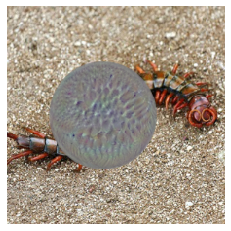

tick                           0.41
hermit crab                    0.14
fiddler crab                   0.07
chambered nautilus, pearly ... 0.04
partridge                      0.04



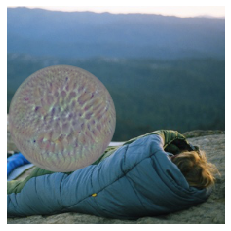

jellyfish                      0.08
chambered nautilus, pearly ... 0.06
mushroom                       0.06
baseball                       0.03
sturgeon                       0.02



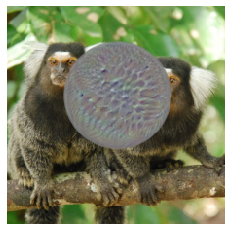

marmoset                       0.64
titi, titi monkey              0.25
squirrel monkey, Saimiri sc... 0.02
partridge                      0.01
acorn                          0.01



{'logloss': 2.228923766145,
 'loss': 9.289862632751465,
 'time': 0.6253910064697266,
 'top5': 0,
 'win': 0}

In [54]:
m = MM.nc['vgg16']
m.patch(regular_training_model_to_patch['vgg16'])
report(m, n=16, show_images=3, scale=0.5)

In [55]:
regular_training_model_to_patch = load_obj("regular_training_model_to_patch")

# Load models
models = []
for m in model_targets:
  M = MM.nc[m]
  M.patch(regular_training_model_to_patch[m])
  models.append(M)

regular_training_win_rates = calculate_win_rates(models)

save_obj(regular_training_win_rates, "regular_training_win_rates")


UnicodeDecodeError: ignored

In [0]:
regular_training_win_rates = load_obj("regular_training_win_rates")
plot_win_rates(regular_training_win_rates, model_targets, "Single-model attack success rates")

## Transfer Attack (AKA Blackbox)

In [0]:
LR = 5.0

STEPS = 500
transfer_ensemble_model_names = ['resnet50', 'xception', 'inceptionv3', 'vgg16']
transfer_target_model =  'vgg19'


print("Beginning blackbox experiment with ensemble: %s and target %s" % (
    transfer_ensemble_model_names, transfer_target_model))
MM.reset_patch()

for i in range(STEPS):
  for mm in transfer_ensemble_model_names:
    loss = MM.train_step(mm, steps=1, learning_rate=LR)

  if i % int(STEPS/10) == 0:
    print("[%s] loss: %s" % (i, loss))

transfer_patch = MM.patch()
save_obj(transfer_patch, "transfer_patch")
  

In [0]:
m = MM.nc[transfer_target_model]
m.patch(transfer_patch)

_ = report(m, n=16, show_images=3, scale=0.5)

In [0]:
transfer_patch = load_obj("transfer_patch")

m = MM.nc[transfer_target_model]
m.patch(transfer_patch)
  
transfer_attack_win_rates = calculate_win_rates([m])

save_obj(transfer_attack_win_rates, "transfer_attack_win_rates")

In [0]:
transfer_attack_win_rates = load_obj("transfer_attack_win_rates")
plot_win_rates(transfer_attack_win_rates, ['vgg19 - Blackbox transfer attack'], "blackbox model attack success rates")

## Whitebox Ensemble Attack

In [0]:
# Cross Model Attack
STEPS = 1000

start = time.time()
MM.reset_patch()

for i in range(STEPS):
  loss = MM.train_step()
  if i % int(STEPS/20) == 0:
    print("[%s] loss: %s" % (i, loss))
  
cross_model_patch = MM.patch()

end = time.time()
mins = (end - start) / 60.0

print('Finished in {:.0f}m'.format(mins))
save_obj(cross_model_patch, "cross_model_patch")


In [0]:
cross_model_patch = load_obj("cross_model_patch")

m = MM.nc['inceptionv3']
m.patch(cross_model_patch)

report(m, n=16, show_images=3, scale=0.3)


In [0]:
cross_model_patch = load_obj("cross_model_patch")

models = []
for m in MODEL_NAMES:
  M = MM.nc[m]
  M.patch(cross_model_patch)
  models.append(M)
  
cross_model_win_rates = calculate_win_rates(models)

save_obj(cross_model_win_rates, "cross_model_win_rates")


In [0]:
cross_model_win_rates = load_obj("cross_model_win_rates")
plot_win_rates(cross_model_win_rates, MODEL_NAMES, "Cross-model attack success rates")

## True Toaster

In [0]:
toaster = load_image('/content/adversarial_patch/toaster.png')

models = []
for m in MODEL_NAMES:
  M = MM.nc[m]
  M.patch(toaster)
  models.append(M)
  
m = MM.nc['inceptionv3']
report(m, n=16, show_images=3, scale=0.5)

In [0]:
toaster_win_rates = calculate_win_rates(models)
save_obj(toaster_win_rates, "toaster_win_rates")

In [0]:
cross_model_win_rates = load_obj("toaster_win_rates")
plot_win_rates(toaster_win_rates, MODEL_NAMES, "Real toaster success rate")